In [36]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

import logging
logging.getLogger('rpy2').setLevel(logging.WARNING)

%load_ext autoreload
%autoreload 2
# from ipython import autoreload
import numpy as np
import itertools
import yaml
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import causallearn
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.search.ConstraintBased.FCI import fci
import random

from clustercausal.algorithms.ClusterPC import ClusterPC
from clustercausal.algorithms.ClusterFCI import ClusterFCI
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.experiments.Evaluator import Evaluator
# from clustercausal.experiments.ExperimentRunner import ExperimentRunner
from clustercausal.experiments.ExperimentRunnervsFCITiers import (
    ExperimentRunner,
)
from clustercausal.utils.Utils import *
from clustercausal.experiments.Utils import load_experiment_folder
from clustercausal.utils.Utils import *
from clustercausal.experiments.Simulator import Simulator
from clustercausal.algorithms.FCITiers import fci_tiers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
data = load_experiment_folder('clustercausal\experiments\_results')

In [38]:
arrow_metrics = ['base_arrow_precision', 'cluster_arrow_precision', 'fcitiers_arrow_precision',\
                'base_arrow_recall', 'cluster_arrow_recall', 'fcitiers_arrow_recall',\
                'base_arrow_f1_score', 'cluster_arrow_f1_score', 'fcitiers_arrow_f1_score']
prec_recall_metrics_with_fcitiers = ['base_adj_precision', 'cluster_adj_precision', 'fcitiers_adj_precision',\
              'base_adj_recall', 'cluster_adj_recall', 'fcitiers_adj_recall', \
                'base_adj_f1_score', 'cluster_adj_f1_score', 'fcitiers_adj_f1_score']
extended_metrics = prec_recall_metrics_with_fcitiers + ['base_base_shd', 'cluster_cluster_shd', 'fcitiers_fcitiers_shd', 'Base indep tests', 'Cluster indep tests']
all_metrics = extended_metrics + arrow_metrics
data[all_metrics]

,base_adj_precision,cluster_adj_precision,fcitiers_adj_precision,base_adj_recall,cluster_adj_recall,fcitiers_adj_recall,base_adj_f1_score,cluster_adj_f1_score,fcitiers_adj_f1_score,base_base_shd,...,Cluster indep tests,base_arrow_precision,cluster_arrow_precision,fcitiers_arrow_precision,base_arrow_recall,cluster_arrow_recall,fcitiers_arrow_recall,base_arrow_f1_score,cluster_arrow_f1_score,fcitiers_arrow_f1_score
0,1.000000,1.000000,1.000000,0.459459,0.513514,0.513514,0.629630,0.678571,0.678571,30.0,...,1059.0,0.666667,0.851852,0.909091,0.326531,0.469388,0.408163,0.438356,0.605263,0.563380
1,0.529412,0.500000,0.523810,0.214286,0.238095,0.261905,0.305085,0.322581,0.349206,51.0,...,877.0,0.347826,0.464286,0.500000,0.148148,0.240741,0.203704,0.207792,0.317073,0.289474
2,0.545455,0.529412,0.466667,0.162162,0.243243,0.189189,0.250000,0.333333,0.269231,40.0,...,666.0,0.166667,0.428571,0.466667,0.041667,0.250000,0.145833,0.066667,0.315789,0.222222


In [39]:
prec_recall_metrics_with_pruned = ['base_adj_precision', 'pruned_base_adj_precision', 'fcitiers_adj_precision', 'cluster_adj_precision', \
           'base_adj_recall', 'pruned_base_adj_recall', 'fcitiers_adj_recall', 'cluster_adj_recall', \
           'base_adj_f1_score', 'pruned_base_adj_f1_score',  'fcitiers_adj_f1_score', 'cluster_adj_f1_score']
data[prec_recall_metrics_with_pruned]
f1_score_metrics = ['base_adj_f1_score', 'cluster_adj_f1_score', 'fcitiers_adj_f1_score', 'pruned_base_adj_f1_score']
data[f1_score_metrics]

,base_adj_f1_score,cluster_adj_f1_score,fcitiers_adj_f1_score,pruned_base_adj_f1_score
0,0.629630,0.678571,0.678571,0.629630
1,0.305085,0.322581,0.349206,0.305085
2,0.250000,0.333333,0.269231,0.250000


load from a graph

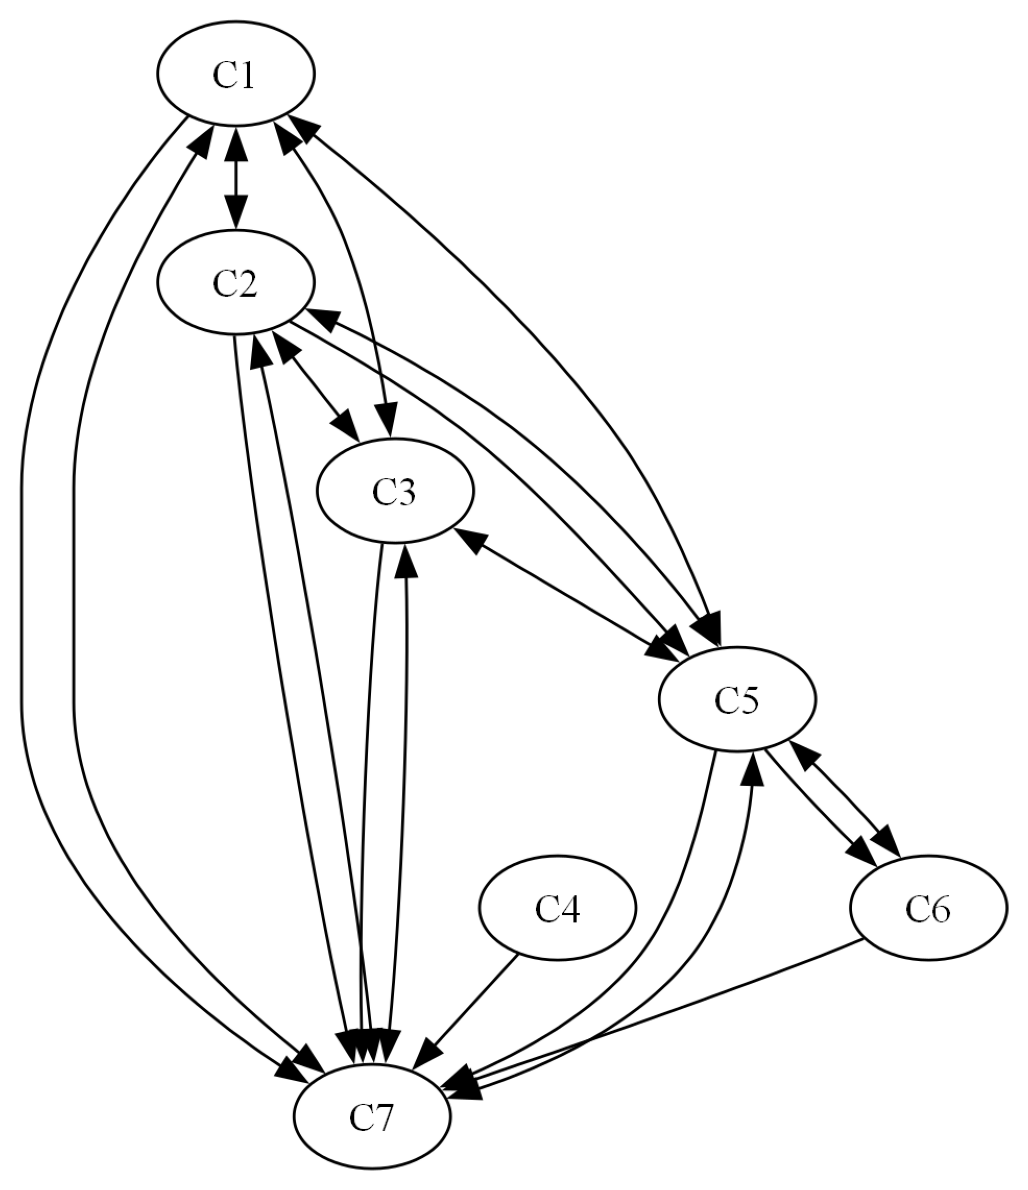

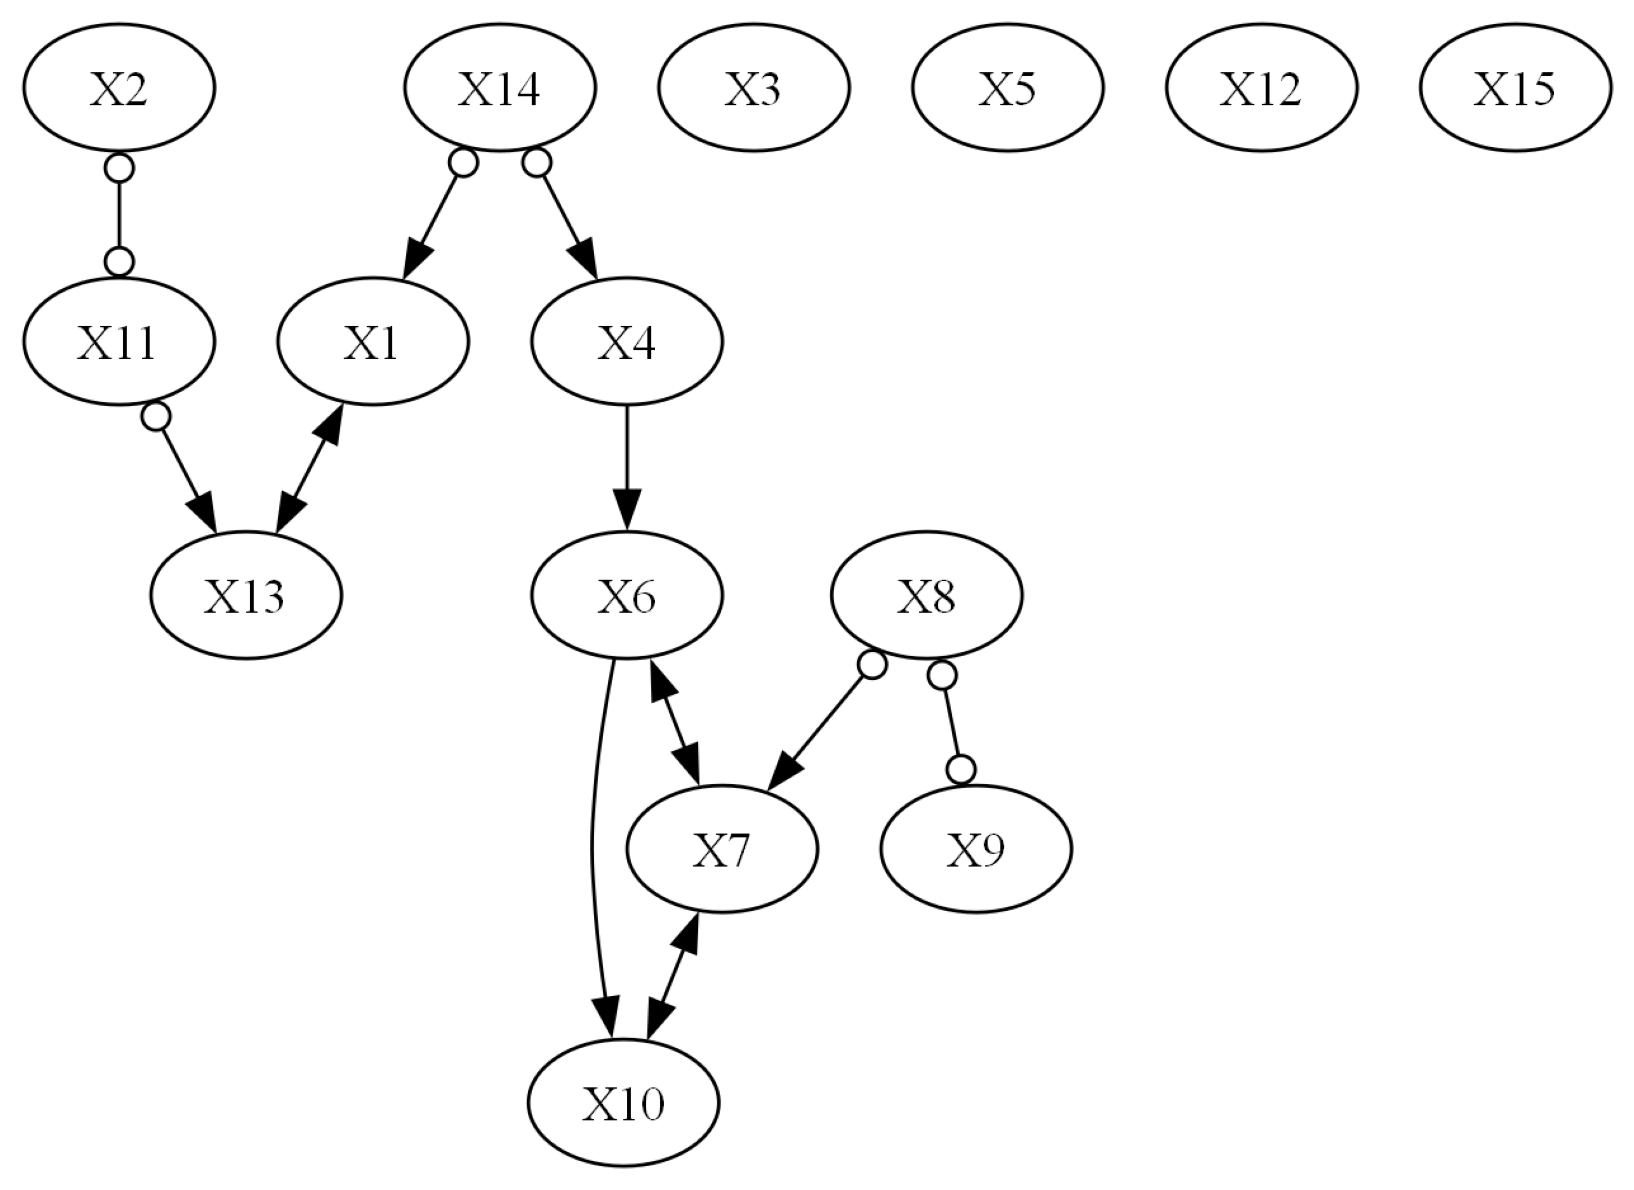

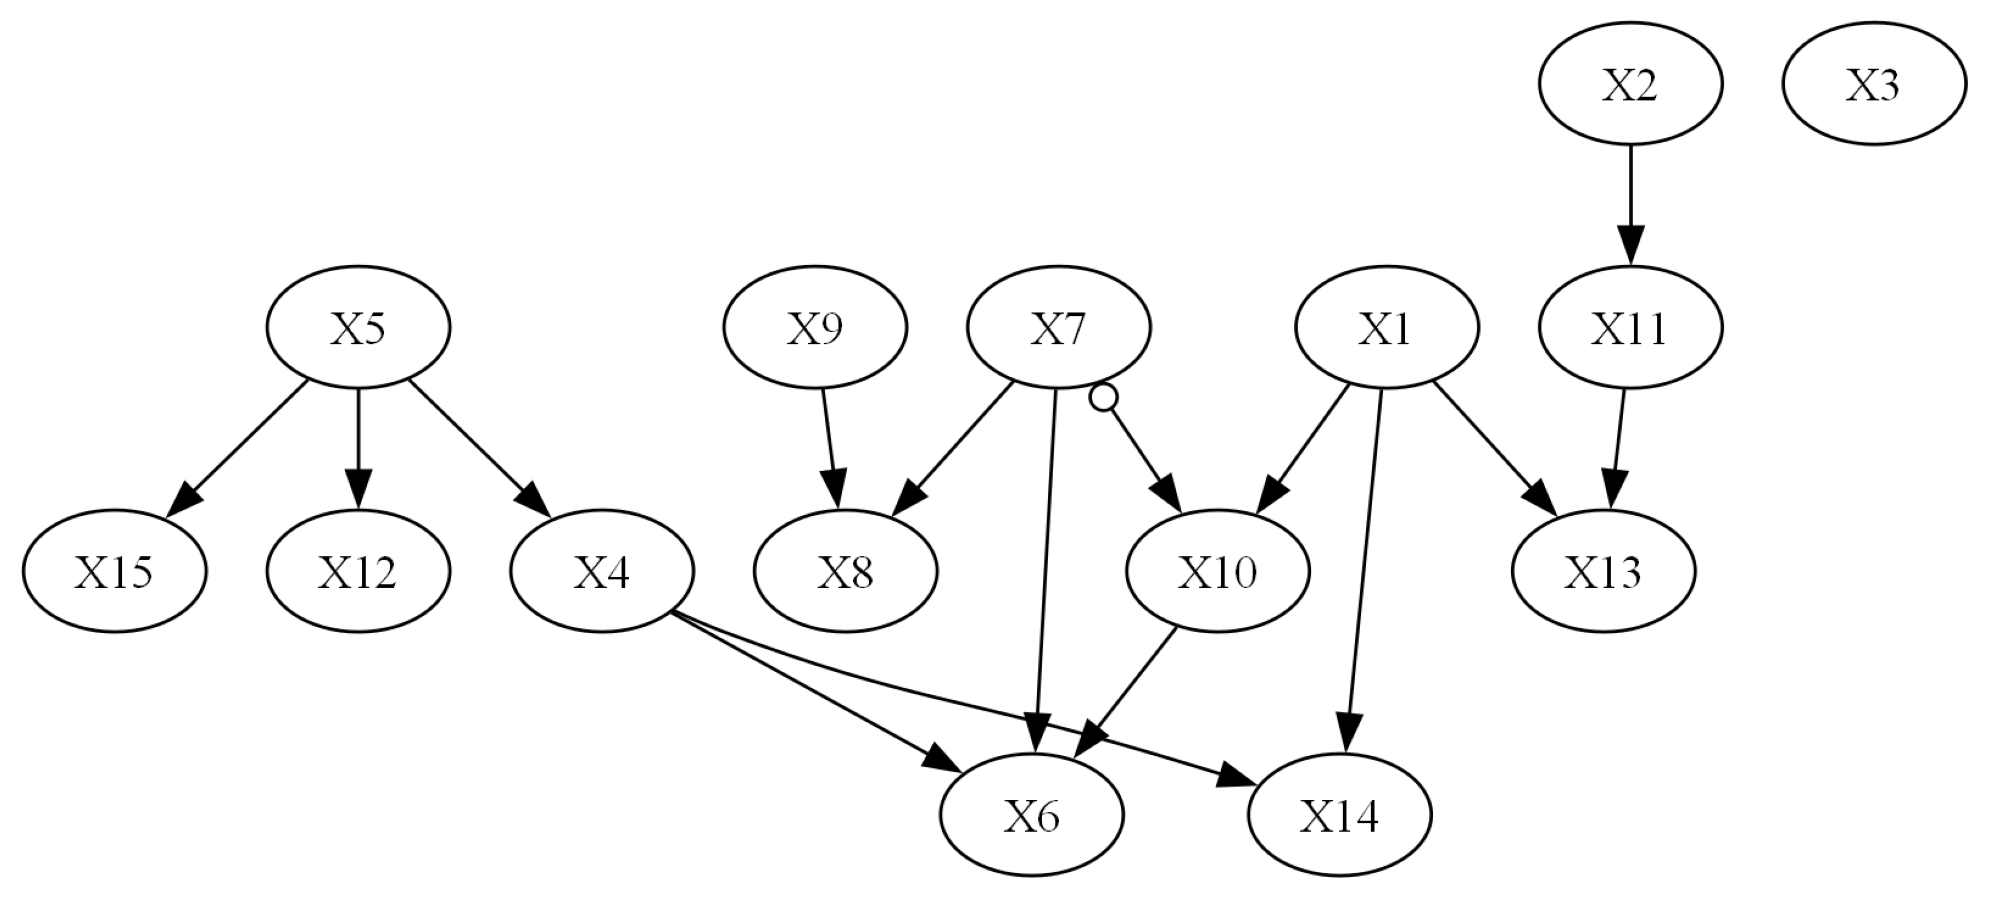

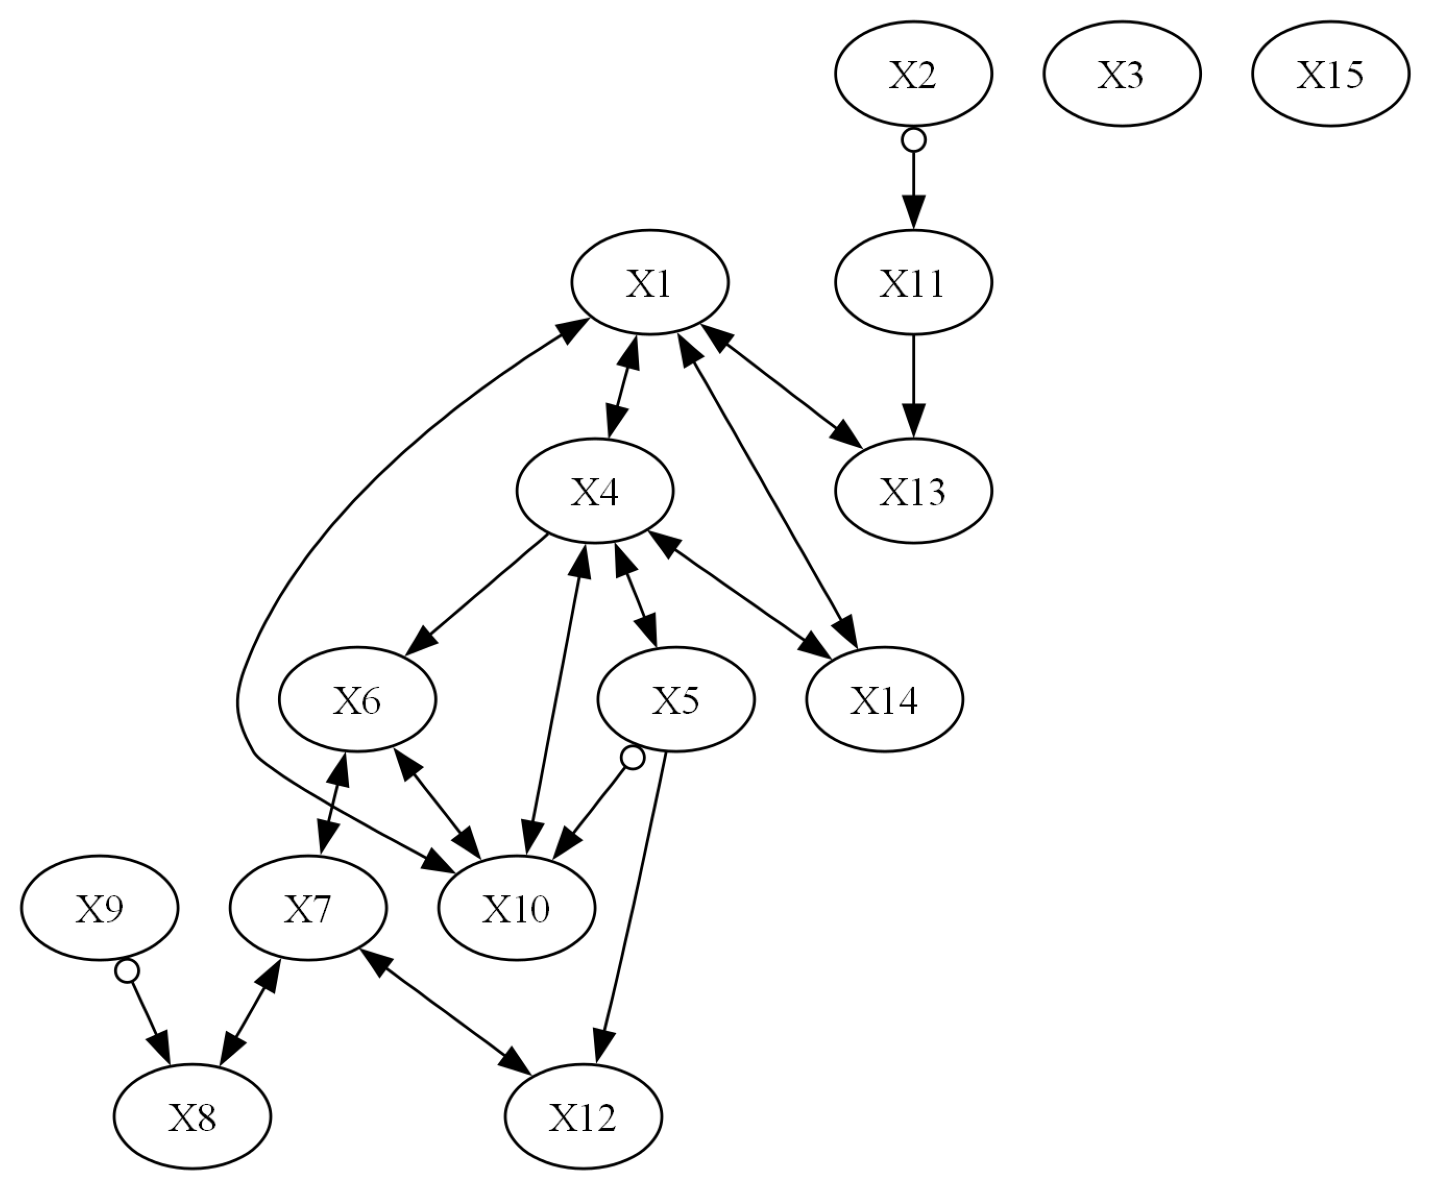

In [40]:
#clustercausal\experiments\_results\ClusterFCI_2024-12-20 11-58-31.118336\erdos_renyi_15_nodes_20_edges_7_clusters_gauss_run8_11-59-40-170
path = "clustercausal\experiments\_results\\test\erdos_renyi_15_nodes_30_edges_7_clusters_gauss_run8_12-04-26-628"
path = "clustercausal\experiments\_results\\test\erdos_renyi_15_nodes_30_edges_7_clusters_gauss_run9_12-04-27-096"
# path = "clustercausal\experiments\_results\\test\erdos_renyi_15_nodes_30_edges_7_clusters_gauss_run10_12-04-27-676"
base_cg, cluster_cg, tiers_cg, cdag = load_experiment_graphs(path)
cdag.cluster_mapping
cdag.cluster_graph.draw_pydot_graph()
base_cg.draw_pydot_graph()
tiers_cg.draw_pydot_graph()
cluster_cg.draw_pydot_graph()
with open(f"{path}\\results.yaml") as file:
    results = yaml.load(file, Loader=yaml.FullLoader)

In [41]:
pd.DataFrame(results)

,base_evaluation_results,cluster_evaluation_results,fcitiers_evaluation_results,pruned_base_evaluation_results,settings
adj_f1_score,0.250000,0.333333,0.269231,0.250000,NaN
adj_false_negative,31.000000,28.000000,30.000000,31.000000,NaN
adj_false_positive,5.000000,8.000000,8.000000,5.000000,NaN
adj_precision,0.545455,0.529412,0.466667,0.545455,NaN
adj_recall,0.162162,0.243243,0.189189,0.162162,NaN
adj_true_negative,63.000000,60.000000,60.000000,63.000000,NaN
adj_true_positive,6.000000,9.000000,7.000000,6.000000,NaN
arrow_f1_score,0.066667,0.315789,0.222222,0.066667,NaN
arrow_f1_score_ce,0.333333,0.857143,0.875000,0.333333,NaN
arrow_false_negative,46.000000,36.000000,41.000000,46.000000,NaN
